# **Task: Policy based Deep Reinforcement Learning**

- You need to Play with the hyper parameters for the **PPO Agent** and another for **PPO Training** and try to understand their consequences

- Train your reinforcement learning model and then test it. Your goal is to ensure that the vehicle avoids collisions, maintains a position as far to the right as possible, and drives at the designated target speed on the highway.

## **Warning Up**

Loading the python modules

### Please ignore the errors
- E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
- E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
- E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
- I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
- To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.

In [1]:
# <<<<<<<<<<<<<<<< Do not change ! <<<<<<<<<<<<<<<<
# Warming up
import os
import shutil
import highway_env
import gymnasium as gym 
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.distributions import Categorical 
from gymnasium.wrappers import RecordVideo 
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

ModuleNotFoundError: No module named 'torch'

In [ ]:
# <<<<<<<<<<<<<<<< Do not change ! <<<<<<<<<<<<<<<<
# check model folder and delete old model
import os
import shutil

folder_path = "highway_ppo"

if os.path.exists(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path) 
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  
        except Exception as e:
            print(f"Can not delete {file_path} because of {e}")
else:
    print("Folder not existed")

# **PPO Actor-Critic Network**

## 1. **Actor Network (`ActorNetwork`)**

- **Purpose**: Predicts a probability distribution over possible actions given the current state.
- **Key Components**:
  - **`__init__` Method**:
    - **`input_dims`**: Number of features representing the current state.
    - **`n_actions`**: Total number of possible actions.
    - **Network Architecture**:
      - `nn.Linear(input_dims, hidden_dim)`: Fully connected layer transforming the input into a hidden representation.
      - `nn.ReLU()`: Activation function introducing non-linearity.
      - Another `nn.Linear(hidden_dim, hidden_dim)` with a `ReLU()` for deeper learning.
      - `nn.Linear(hidden_dim, n_actions)`: Final layer producing raw scores (logits) for each action.
      - `nn.Softmax(dim=-1)`: Converts logits to a probability distribution across actions.
    - **`self.to(device)`**: Moves the network to GPU if available.

  - **`forward` Method**:
    - Processes the input state through the network to generate action probabilities.
    - Wraps the output with `Categorical` from PyTorch, enabling easy sampling and log-probability calculations.

---

## 2. **Critic Network (`CriticNetwork`)**

- **Purpose**: Estimates the value of the current state, which helps in reducing variance during training.
- **Key Components**:
  - **`__init__` Method**:
    - **`input_dims`**: Number of input state features.
    - **Network Architecture**:
      - Similar structure as the actor network but with a final output layer of size 1, representing the scalar value of the state.
    - **`self.to(device)`**: Moves the network to GPU if available.

  - **`forward` Method**:
    - Processes the input state and outputs the scalar value estimate.

---

## 3. **Key Points**
- **Device Compatibility**: Both models use `self.to(device)` for GPU acceleration if available.
- **Categorical Distribution**: The actor network uses `Categorical` to handle discrete action spaces, making sampling and backpropagation easier.
- **Softmax**: Ensures that action probabilities sum up to 1.
- **Value Output**: The critic outputs a single value representing the expected return from the given state.

---

This architecture forms the foundation for PPO algorithms, where:
- The **actor** decides "what action to take."
- The **critic** evaluates "how good the current state is."

---

# **PPO Base Class Explanation**

---

## 1. **Initialization (`__init__` Method)**

- **Parameters**:
  - `input_dims`: Number of input state features.
  - `n_actions`: Total number of possible actions.
  - `pi_lr`: Learning rate for the policy (actor) network.
  - `vf_lr`: Learning rate for the value function (critic) network.
  - `hidden_dim`: Size of hidden layers for the neural networks.

- **Core Components**:
  - **Actor Network**: Initialized using the `ActorNetwork` class.
  - **Critic Network**: Initialized using the `CriticNetwork` class.
  - **Optimizers**:
    - `self.actor_optimizer`: Optimizer for the actor network using the Adam optimizer.
    - `self.critic_optimizer`: Optimizer for the critic network using the Adam optimizer.
  - **Memory**: 
    - `self.memory = PPOMemory()`: Initializes memory for storing experiences.

---

## 2. **Experience Storage (`remember` Method)**

- **Purpose**: Stores an experience tuple consisting of:
  - `state`: The observed state.
  - `action`: The action taken.
  - `probs`: Log-probability of the taken action.
  - `vals`: Estimated value of the state.
  - `reward`: The reward received after the action.
  - `done`: Boolean indicating if the episode has terminated.

- **Implementation**: Appends each component to the corresponding list in the memory object.

---

## 3. **Action Selection (`choose_action` Method)**

- **Purpose**: 
  - Selects an action based on the current policy.
  - Returns the chosen action, its log-probability, and the critic's value estimate.

- **Process**:
  - **State Conversion**: Converts the observation to a PyTorch tensor and moves it to the specified device.
  - **Distribution and Value**:
    - `dist = self.actor(state)`: Gets the action distribution.
    - `value = self.critic(state)`: Estimates the state value.
  - **Sampling**: 
    - `action = dist.sample()`: Samples an action from the distribution.
  - **Output Processing**:
    - `probs`: Extracts the log-probability of the action.
    - `action`: Converts the action to a scalar.
    - `value`: Converts the value to a scalar.

---

## 4. **Model Saving (`save_models` Method)**

- **Purpose**: Saves the actor and critic models to the specified directory.


---

## 5. **Model Loading (`load_models` Method)**

- **Purpose**: Loads previously saved actor and critic models from disk.

---

This `PPOBase` class is structured for flexibility and ease of extension, supporting essential PPO functionalities and enabling straightforward integration into reinforcement learning pipelines.+


In [ ]:
# <<<<<<<<<<<<<<<< Do not change ! <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<< Custom PPO Model Implementation for Highway Environment <<<<<<<<<<<<<<<<<<<
# Custom implemented PPO based on: https://spinningup.openai.com/en/latest/algorithms/ppo.html

def plot_scores(scores):
    """
    Plots training scores over episodes.

    Args:
        scores (list): List of episode scores recorded during training.
    """
    plt.figure(figsize=(10, 5))  # Define figure size
    plt.plot(scores, label='Score per Episode', alpha=0.6)  # Plot episode scores
    
    # Label the plot
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('Training Performance')
    plt.legend()
    plt.grid(True)
    
    # Display the plot
    plt.show()

# Check if a GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Memory buffer for PPO training
class PPOMemory:
    def __init__(self):
        """ Initializes memory storage for PPO training. """
        self.states = []  # Stores observed states
        self.actions = []  # Stores actions taken
        self.probs = []  # Stores action log probabilities
        self.vals = []  # Stores state value estimates
        self.rewards = []  # Stores received rewards
        self.dones = []  # Stores done flags (whether episode ended)

    def clear(self):
        """ Clears the stored memory after an update. """
        self.states = []
        self.actions = []
        self.probs = []
        self.vals = []
        self.rewards = []
        self.dones = []

    def generate_batches(self, batch_size):
        """ Generates randomized batches of stored experiences for training. """
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+batch_size] for i in batch_start]
        return batches

# Actor network (policy network)
class ActorNetwork(nn.Module):
    def __init__(self, input_dims, n_actions, hidden_dim=64):
        """ 
        Initializes the actor network, which predicts action probabilities.
        Args:
            input_dims: Number of state features.
            n_actions: Number of possible actions.
        """
        super(ActorNetwork, self).__init__()
        
        self.actor = nn.Sequential(
            nn.Linear(input_dims, hidden_dim),  # Fully connected layer with 64 neurons
            nn.ReLU(),  # Activation function
            nn.Linear(hidden_dim, hidden_dim),  # Another fully connected layer
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions),  # Output layer with one neuron per action
            nn.Softmax(dim=-1)  # Softmax activation for probability distribution
        )
        self.to(device)  # Move the model to GPU if available

    def forward(self, state):
        """ Computes the action distribution for a given state. """
        dist = self.actor(state)
        dist = Categorical(dist)  # Convert output into categorical distribution
        return dist

# Critic network (value function)
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, hidden_dim=64):
        """ 
        Initializes the critic network, which estimates state values.
        Args:
            input_dims: Number of state features.
        """
        super(CriticNetwork, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(input_dims, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Single output for state value estimation
        )
        self.to(device)  # Move the model to GPU if available

    def forward(self, state):
        """ Computes the state value. """
        value = self.critic(state)
        return value

class PPOBase:
    def __init__(self, 
                 input_dims, 
                 n_actions, 
                 pi_lr=3e-4, 
                 vf_lr=3e-4, 
                 hidden_dim=64):
        """
        Initializes the PPO agent.
        Args:
            input_dims: Number of state features.
            n_actions: Number of possible actions.
            pi_lr: Learning rate for the policy network.
            vf_lr: Learning rate for the value function.
            hidden_dim: Dimension of CNN hidden layer
        """
        self.actor = ActorNetwork(input_dims, n_actions, hidden_dim).to(device)
        self.critic = CriticNetwork(input_dims, hidden_dim).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=pi_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=vf_lr)
        self.memory = PPOMemory()

    def remember(self, state, action, probs, vals, reward, done):
        """ Stores experience in memory. """
        self.memory.states.append(state)
        self.memory.actions.append(action)
        self.memory.probs.append(probs)
        self.memory.vals.append(vals)
        self.memory.rewards.append(reward)
        self.memory.dones.append(done)

    def choose_action(self, observation):
        """ Selects an action based on policy and returns its log probability and value estimate. """
        state = torch.FloatTensor(observation).to(device)
        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = torch.squeeze(dist.log_prob(action)).item()
        action = torch.squeeze(action).item()
        value = torch.squeeze(value).item()

        return action, probs, value

    def save_models(self, path):
        """ Saves the trained models to disk. """
        if not os.path.exists(path):
            os.makedirs(path)
        torch.save(self.actor.state_dict(), os.path.join(path, 'actor.pth'))
        torch.save(self.critic.state_dict(), os.path.join(path, 'critic.pth'))
        print(f"Models saved to {path}")

    def load_models(self, path):
        """ Loads trained models from disk. """
        self.actor.load_state_dict(torch.load(os.path.join(path, 'actor.pth')))
        self.critic.load_state_dict(torch.load(os.path.join(path, 'critic.pth')))
        print(f"Models loaded from {path}")

Using device: cuda


# **PPO Agent**

Source:

- https://arxiv.org/abs/1707.06347

- https://spinningup.openai.com/en/latest/algorithms/ppo.html

- https://nn.labml.ai/rl/ppo/index.html

### 1. **Class Initialization**
- **Parameters:**
  - \( $\gamma$ \): Discount factor for future rewards.
  - \( $\lambda$ \): Lambda for Generalized Advantage Estimation (GAE).
  - \( $\epsilon$ \): Clipping parameter for PPO to prevent too large policy updates.
  - \( $batch\_size$ \): Number of samples per training batch.
  - \( $train\_pi\_iters$ \): Number of iterations for policy network updates per learning step.

### 2. **Learning Process**
The PPO training process involves several steps, outlined below:

---

#### Step 1: **Generalized Advantage Estimation (GAE)**
- The **Temporal Difference (TD) error** is calculated as:

$$
\delta_t = r_t + \gamma V(s_{t+1})(1 - d_t) - V(s_t)
$$

where:
- \($r_t$\) is the reward at time \($t$\).
- \($V(s_t)$\) is the value function estimate at state \($s_t$\).
- \($d_t$\) is the done flag (1 if the episode ends, 0 otherwise).

- The **Advantage** \($A_t$\) is computed using:

$$
A_t = \sum_{l=0}^{T-t-1} (\gamma \lambda)^l \delta_{t+l}
$$

This accounts for future rewards, discounted by \($\gamma$\) and \($\lambda$\).

---

#### Step 2: **Policy Update (Actor)**
- The **probability ratio** is calculated as:

$$
r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)}
$$

- The **clipped objective** is:

$$
L^{\text{CLIP}}(\theta) = \mathbb{E}_t\left[ \min\left(r_t(\theta)A_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon)A_t \right) \right]
$$

This helps to avoid large updates that could destabilize training.

- The **actor loss** is computed as the negative mean of the clipped objective:

$$
L^{\text{Actor}} = -\mathbb{E}_t\left[ \min\left(r_t(\theta)A_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon)A_t \right) \right]
$$

This loss guides the optimization of the policy network.

---

#### Step 3: **Value Function Update (Critic)**
- The **value loss** is computed as the mean squared error between predicted values and actual returns:

$$
L^{\text{VF}} = \mathbb{E}_t \left[ \left( V(s_t) - R_t \right)^2 \right]
$$

where \($R_t = A_t + V(s_t)$\) is the target return.

---

### Step 4: **Optimization Process**
- The actor and critic networks are updated separately by minimizing their respective losses.

---

### Step 5: **Memory Management**
- After each learning cycle, the memory buffer is cleared to prepare for the next batch of experience collection.

---


In [ ]:
# PPO Agent for learning process
class PPOAgent:
    def __init__(self, 
                 base,
                 gamma=0.99,
                 lam=0.95, 
                 clip_ratio=0.2, 
                 batch_size=64,
                 train_pi_iters=10):
        """
        Initializes the PPO agent.
        Args:
            base: Class ppo base

            gamma: Discount factor for future rewards.
            lam: Lambda for generalized advantage estimation (GAE).
            clip_ratio: Clipping ratio for PPO loss.
            batch_size: Number of experiences in each training batch.
            train_pi_iters: Number of iterations for policy network update per learning step.
        """
        self.base = base
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.train_pi_iters = train_pi_iters
        self.lam = lam
        self.batch_size = batch_size

    def learn(self):
        """ 
        Performs PPO training on stored experiences.

        The training consists of:
        1. Computing **Generalized Advantage Estimation (GAE)** for advantage calculation.
        2. Updating **Actor (Policy) Network** using PPO loss.
        3. Updating **Critic (Value) Network** using Mean Squared Error (MSE) loss.

        This function follows the Proximal Policy Optimization (PPO) algorithm to improve the policy using collected experiences.
        """
        self.memory = self.base.memory
        for _ in range(self.train_pi_iters):  # Train policy multiple times per batch

            # Convert stored memory into PyTorch tensors and move them to GPU if available
            state_arr = torch.FloatTensor(np.array(self.memory.states)).to(device)  # Convert states to tensor
            action_arr = torch.LongTensor(np.array(self.memory.actions)).to(device)  # Convert actions to tensor
            old_prob_arr = torch.FloatTensor(np.array(self.memory.probs)).to(device)  # Convert old action probabilities
            vals_arr = torch.FloatTensor(np.array(self.memory.vals)).to(device)  # Convert value function estimates

            # Step 1: Compute **Generalized Advantage Estimation (GAE)**
            advantages = np.zeros(len(self.memory.rewards), dtype=np.float32)  # Initialize advantage array
            returns = np.zeros(len(self.memory.rewards), dtype=np.float32)  # Initialize return array

            for t in range(len(self.memory.rewards) - 1):  # Iterate over stored rewards
                discount = 1  # Discount factor for advantage estimation
                a_t = 0  # Initialize advantage estimate

                # Compute advantage using GAE (Generalized Advantage Estimation)
                for k in range(t, len(self.memory.rewards) - 1):
                    td_error = self.memory.rewards[k] + self.gamma * vals_arr[k + 1].item() * (1 - self.memory.dones[k]) - vals_arr[k].item()
                    a_t += discount * td_error  # Accumulate discounted temporal difference error
                    discount *= self.gamma * self.lam  # Apply discount factor and lambda

                advantages[t] = a_t  # Store computed advantage

            advantages = torch.FloatTensor(advantages).to(device)  # Convert advantages to tensor

            # Generate training batches
            batches = self.memory.generate_batches(self.batch_size)

            # Update **Actor (Policy) Network** and **Critic (Value) Network**
            for batch in batches:
                states = state_arr[batch]  # Extract batch of states
                old_probs = old_prob_arr[batch]  # Extract batch of old action probabilities
                actions = action_arr[batch]  # Extract batch of actions taken

                # Forward pass through Actor (Policy Network) to compute action probabilities
                dist = self.base.actor(states)  # Get probability distribution over actions
                new_probs = dist.log_prob(actions)  # Compute log probability of selected actions

                # Forward pass through Critic (Value Network) to estimate state value
                critic_value = self.base.critic(states)  # Get value function predictions
                critic_value = torch.squeeze(critic_value)  # Remove extra dimensions

                # Step 2:Policy Update
                # Compute probability ratio for PPO loss
                prob_ratio = torch.exp(new_probs - old_probs)
                
                # Compute **PPO Clipped Surrogate Objective**
                weighted_probs = advantages[batch] * prob_ratio  # Compute policy loss without clipping
                weighted_clipped_probs = torch.clamp(prob_ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages[batch]  # Apply PPO clipping
                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()  # Final actor loss

                # Compute **Critic Loss** (Mean Squared Error between predicted values and returns)
                returns = advantages[batch] + vals_arr[batch]  # Compute target return
                critic_loss = nn.MSELoss()(critic_value, returns)  # Compute MSE loss for value function

                # Step 4-1: Optimize Actor (Policy) Network
                self.base.actor_optimizer.zero_grad()  # Reset gradients
                actor_loss.backward()  # Compute gradients
                self.base.actor_optimizer.step()  # Apply gradient update

                # Step 4-2: Optimize Critic (Value) Network
                self.base.critic_optimizer.zero_grad()  # Reset gradients
                critic_loss.backward()  # Compute gradients
                self.base.critic_optimizer.step()  # Apply gradient update

        # Step 5: Clear stored experiences after training
        self.memory.clear()

# **PPO Training - Highway Environment**

This part is designed to train an agent using the **PPO (Proximal Policy Optimization)** algorithm in the `highway-fast-v0` environment.

---

## **Key Process Summary**

### **1. Environment Initialization**
- Create the `highway-fast-v0highway-fast-v0` environment using `gym.make()`.
- Extract:
  - **Input Dimensions**: Based on the shape of `np.prod(env.observation_space.shape)`.
  - **Number of Actions**: Extracted via `env.action_space.n`.

### **2. Random Seed (optional)**
- Set random seeds to ensure reproducibility:
  - `torch.manual_seed(seed)`
  - `np.random.seed(seed)`
  - Apply seed during environment reset: `env.reset(seed=seed)`.

---

### **3. PPO Agent Initialization**
- **PPOBase** network configuration:
  - `pi_lr=3e-4`: Learning rate for the policy network.
  - `vf_lr=3e-4`: Learning rate for the value function.
  - `hidden_dim=64`: Dimension of hidden layers.

- **PPOAgent** configuration:
  - `gamma=0.99`: Discount factor to weigh future rewards.
  - `lam=0.95`: Lambda for Generalized Advantage Estimation (GAE).
  - `clip_ratio=0.2`: PPO clipping parameter to limit policy update changes.
  - `batch_size=64`: Batch size for each training update.
  - `train_pi_iters=10`: Number of policy update iterations per learning step.

---

### **4. Training Process**
- Set overall training parameters:
  - `episodes=500`: Total number of training episodes.
  - `steps_per_epoch=256`: Maximum number of steps per training epoch.
  - `max_ep_len=256`: Maximum length of a single learning process.

- Steps within each episode:
  1. Reset the environment and initialize `done` and `score`.
  2. Loop through the following steps until `done` or reaching `steps_per_epoch`:
     - **State Processing**: Flatten the observation data to match PPO network input.
     - **Action Selection**: Use `ppo_base.choose_action()` to select an action based on the current policy.
     - **Environment Interaction**: Execute the action using `env.step()`, and collect the next state and reward.
     - **Memory Storage**: Store observation, action, probability, value, reward, and done flag in PPO memory.
     - **Periodic Training**: Perform `agent.learn()` after every `max_ep_len` steps to update the policy.

---

### **5. Model Saving and Monitoring**
- At the end of each episode:
  - Record the `score` and calculate the moving average of the last 100 episodes.
  - If the current score surpasses the historical best, save the model using `ppo_base.save_models('highway_ppo')`.

---

### **6. Training Result Visualization**
- Use `plot_scores(scores)` to visualize the trend of scores across episodes, helping to analyze the learning performance of the agent.

---

### **7. Starting the Training Process**
```python
print("Starting training...")
agent = train()  # Execute the PPO training process


Starting training...
Observation Space: Box(-inf, inf, (5, 5), float32)
Action Space: Discrete(5)
Episode: 0, Score: 2.02, Avg Score: 2.02
Save model with score: 2.02 at episode 0
Models saved to highway_ppo
Episode: 1, Score: 9.70, Avg Score: 5.86
Save model with score: 9.70 at episode 1
Models saved to highway_ppo
Episode: 2, Score: 2.01, Avg Score: 4.58
Episode: 3, Score: 7.85, Avg Score: 5.39
Save model with score: 7.85 at episode 3
Models saved to highway_ppo
Episode: 4, Score: 3.98, Avg Score: 5.11
Episode: 5, Score: 15.88, Avg Score: 6.91
Save model with score: 15.88 at episode 5
Models saved to highway_ppo
Episode: 6, Score: 4.05, Avg Score: 6.50
Episode: 7, Score: 6.95, Avg Score: 6.55
Save model with score: 6.95 at episode 7
Models saved to highway_ppo
Episode: 8, Score: 5.38, Avg Score: 6.42
Episode: 9, Score: 2.91, Avg Score: 6.07
Episode: 10, Score: 4.08, Avg Score: 5.89
Episode: 11, Score: 18.31, Avg Score: 6.93
Save model with score: 18.31 at episode 11
Models saved to h

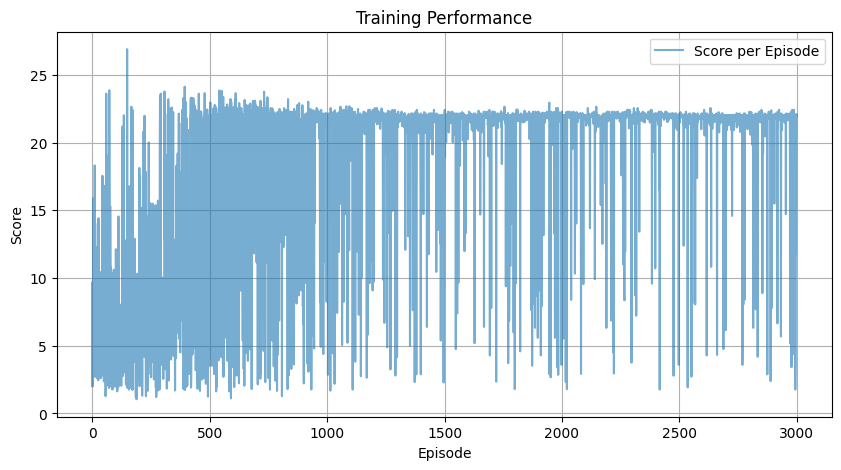

In [ ]:
# Training script for PPO in a MiniGrid environment
def train():
    """
    Trains a PPO agent in the highway-fast-v0 environment.

    Returns:
        PPOAgent: Trained PPO agent.
    """
    # Initialize the MiniGrid environment
    # Environment Documentation https://minigrid.farama.org/environments/minigrid/EmptyEnv/
    env = gym.make('highway-fast-v0')
    
    print("Observation Space:", env.observation_space)
    print("Action Space:", env.action_space)

    # Extract input dimensions based on observation space
    input_dims = np.prod(env.observation_space.shape)
    
    # Extract number of possible actions
    n_actions = env.action_space.n
    
    # Set random seed for reproducibility
    seed = 0
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Reset environment with seed
    _, _ = env.reset(seed=seed)
    
    ############################################################################
    ####### Change the parameters to optimize the training process #############
    ####### BEGINN HERE                                            #############
    # Define and initialize PPO model and agent with updated parameters
    ####### BEGIN HERE                                            #############
    # Define and initialize PPO model and agent with optimized parameters
    ppo_base = PPOBase(
        input_dims,       # Keep as per your environment
        n_actions,        # Keep as per your environment
        pi_lr=3e-4,       # Slightly lower for even more stable policy updates
        vf_lr=3e-4,       # Slightly higher than pi_lr for balanced value learning
        hidden_dim=64    # Increased for better capacity in complex environments
    )
        
    agent = PPOAgent(
        ppo_base,
        gamma=0.99,       # Slightly lower for better handling of immediate rewards
        lam=0.98,         # Slightly lower for flexibility in advantage estimation
        clip_ratio=0.1,   # Relaxed slightly for faster learning while maintaining stability
        batch_size=64,   # Larger for better gradient estimates in complex tasks
        train_pi_iters=5 # More iterations for thorough optimization
    )
    # Define additional parameters for training
    best_score = float('-inf')  # Keep as is
    episodes = 3000             # Reduced for efficiency with better-tuned parameters
    steps_per_epoch = 500       # Increased for more exploration per epoch
    max_ep_len = 500 # Extended to allow longer scenarios for collision avoidance
    ####### END HERE                                            #############    # Keep as is – allows enough room for longer safety-critical scenarios

    ####### END HERE                                            #############
    ############################################################################
    
    # Lists to track scores and averages
    scores = []
    avg_scores = []
    total_step = 0  # Total steps across episodes
    
    for episode in range(episodes):
        observation, _ = env.reset()  # Reset environment at the start of each episode
        done = False  # Track if episode is finished
        score = 0  # Store episode score
        step = 0  # Track steps in episode
        
        while not done and step < steps_per_epoch:
            # Flatten the observation to match input dimensions
            obs_flat = observation.flatten()
            
            # Choose action based on current policy by using choose_action()
            action, prob, val = ppo_base.choose_action(obs_flat)
            
            # Take action in the environment and get new observation by using step()
            next_observation, reward, terminated, truncated, _ = env.step(action)
            
            # Check if episode has ended
            done = terminated or truncated
            
           # Store experience in PPO memory by using remember()
            ppo_base.remember(obs_flat, action, prob, val, reward, done)
            
            # Move to next state
            observation = next_observation
            score += reward  # Accumulate score
            step += 1  # Increase step counter
            total_step += 1  # Update total step counter
            
            # Train the agent after every max_ep_len steps
            if total_step % max_ep_len == 0:
                agent.learn()
        
        # Store episode score
        scores.append(score)
        
        # Compute moving average of last 100 episodes
        avg_score = np.mean(scores[-100:])
        avg_scores.append(avg_score)
        
        # Print episode details
        print(f'Episode: {episode}, Score: {score:.2f}, Avg Score: {avg_score:.2f}')
            
        # Save best model if score improves
        if score > best_score or score > avg_score:
            best_score = score
            print(f'Save model with score: {score:.2f} at episode {episode}')
            ppo_base.save_models('highway_ppo')
    
    # Plot training performance
    plot_scores(scores)

    return agent  # Return trained agent

print("Starting training...")
agent = train()  # Run training function
# ppo_base.save_models('highway_ppo')

In [ ]:
# <<<<<<<<<<<<<<<<<< Switch to SB3 PPO Model <<<<<<<<<<<<<<<<<<<<<<<<<<<<
# PPO Model from stable baseline3 library
# You can commit this block, if you do not use this model instead of custom PPO model

# n_cpu = 6
# batch_size = 64
# env = gym.make("highway-fast-v0", render_mode="rgb_array")
# env = ImgObsWrapper(env)
# model = PPO(
#     "MlpPolicy",
#     env,
#     policy_kwargs=dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])]),
#     n_steps=batch_size * 12 // n_cpu,
#     batch_size=batch_size,
#     n_epochs=10,
#     learning_rate=5e-4,
#     gamma=0.9,
#     verbose=2,
#     tensorboard_log="highway_ppo/",
# )
# # Train the agent
# model.learn(total_timesteps=int(2e4))
# # Save the agent
# model.save("highway_ppo/model")

# **Test with trained model**

In [ ]:
# <<<<<<<<<<<<<<<< Do not change ! <<<<<<<<<<<<<<<<
# check the video folder and delete old videos

folder_path = "videos"

if os.path.exists(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  
        except Exception as e:
            print(f"Can not delete {file_path} because of {e}")
else:
    print("Folder not existed")

In [ ]:
print(agent.base)
print(dir(agent.base))
state_dict = torch.load('highway_ppo/actor.pth')
for k, v in state_dict.items():
    print(f"{k}: {v.shape}")


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'actor', 'actor_optimizer', 'choose_action', 'critic', 'critic_optimizer', 'load_models', 'memory', 'remember', 'save_models']
actor.0.weight: torch.Size([64, 25])
actor.0.bias: torch.Size([64])
actor.2.weight: torch.Size([64, 64])
actor.2.bias: torch.Size([64])
actor.4.weight: torch.Size([5, 64])
actor.4.bias: torch.Size([5])


In [ ]:
# <<<<<<<<<<<<<<<<<< Test with Custom PPO Model <<<<<<<<<<<<<<<<<<<<<<<<<<<<

def test(n_episodes=5):
    env = gym.make('highway-fast-v0', render_mode="rgb_array")
    env = env.unwrapped
    env.configure({
        "duration": 100,
    })
    env = RecordVideo(env, "videos", episode_trigger=lambda x: True)
    
    input_dims = np.prod(env.observation_space.shape)
    n_actions = env.action_space.n
    
    agent = PPOBase(input_dims, n_actions, hidden_dim=64)

    agent.load_models('highway_ppo')
        
    scores = 0
    
    for episode in range(n_episodes):
        observation, _ = env.reset()
        done = False
        score = 0

        while not done:
            obs_flat = observation.flatten()
            action, _, _ = agent.choose_action(obs_flat)
            
            observation, reward, terminated, truncated, _ = env.step(action)
            
            current_lane = env.unwrapped.vehicle.lane_index
            current_speed = env.unwrapped.vehicle.speed
            target_speed = env.unwrapped.vehicle.target_speed
            done = terminated or truncated
                        
            lane_reward = 2.0 if current_lane[2] == len(current_lane) - 1 else 0  
            speed_reward = 1 - abs(current_speed - target_speed)/target_speed 

            collision_reward = 1 if terminated else 0

            custom_reward = reward + 0.3*lane_reward + 0.2*speed_reward - collision_reward

            score += custom_reward
            
        scores += score
        print(f'Test Episode: {episode}, Score: {score}')
    
    score_avg = scores/n_episodes

    print(f'Your final average Score: {score_avg}')
    
    env.close()
    print("Testing completed. Videos saved in 'videos' directory.")
    
print("\nStarting testing and recording...")
test(n_episodes=100)


Starting testing and recording...
Models loaded from highway_ppo


/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/jovyan/highway_ppo/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Test Episode: 0, Score: 152.7117445478979
Test Episode: 1, Score: 153.34597156398092
Test Episode: 2, Score: 39.67397156398104
Test Episode: 3, Score: 30.427891563981056
Test Episode: 4, Score: 9.681704897314116
Test Episode: 5, Score: 153.34597156398092
Test Episode: 6, Score: 153.34597156398092
Test Episode: 7, Score: 31.840329484598033
Test Episode: 8, Score: 149.37930409669548
Test Episode: 9, Score: 153.47868140474574
Test Episode: 10, Score: 35.23930489731438
Test Episode: 11, Score: 150.74565764120516
Test Episode: 12, Score: 153.47930489731425
Test Episode: 13, Score: 153.34597156398092
Test Episode: 14, Score: 147.4459714585256
Test Episode: 15, Score: 146.04597156394922
Test Episode: 16, Score: 152.7117445478979
Test Episode: 17, Score: 153.74534884010455
Test Episode: 18, Score: 147.41263821676048
Test Episode: 19, Score: 153.34597156398092
Test Episode: 20, Score: 153.47930489731425
Test Episode: 21, Score: 153.47930489731425
Test Episode: 22, Score: 152.7117445478979
Test 

In [ ]:
# <<<<<<<<<<<<<<<<<< Switch to SB3 PPO Model <<<<<<<<<<<<<<<<<<<<<<<<<<<<
# model from stable baseline 3
# model = PPO.load("highway_ppo/model")

# env = gym.make("highway-fast-v0", render_mode="rgb_array")
# env = ImgObsWrapper(env)
# env = RecordVideo(env, "videos", episode_trigger=lambda x: True)
# for episode in trange(3, desc='Test episodes'):
#     print(episode)
#     (obs, info), done = env.reset(), False
#     step = 0
#     while not done:
#         action, _ = model.predict(obs, deterministic=True)
#         obs, reward, done, truncated, info = env.step(int(action))
        
#         step += 1
        
#         if step > 1000:
#             break
# env.close()
# print("Testing completed. Videos saved in 'videos' directory.")

In [ ]:
# <<<<<<<<<<<<<<<<<< Do not change ! <<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<< Play Videos <<<<<<<<<<<<<<<<<<<<<<<<<<<<

from pathlib import Path
import base64
import random
from IPython.display import display, HTML

def show_videos(path="videos", playback_rate=1.0, num_videos=10):
    html = []
    video_files = list(Path(path).glob("*.mp4"))
    selected_videos = random.sample(video_files, min(num_videos, len(video_files)))

    for mp4 in selected_videos:
        video_b64 = base64.b64encode(mp4.read_bytes()).decode("ascii")
        html.append(f"""
            <div>
                <video alt="{mp4.name}" autoplay loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{video_b64}" type="video/mp4" />
                </video>
                <script>
                    var video = document.currentScript.previousElementSibling;
                    video.playbackRate = {playback_rate};
                </script>
            </div>
        """)
    
    display(HTML(data="<br>".join(html)))

show_videos()

In [ ]:
import os 

folder_path = "highway_ppo"
if os.path.exists(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Can not delete {file_path} because of {e}")
else:
    print("Folder not existed")

In [ ]:
import os
import glob

videos_folder = 'videos'
video_extensions = ['*.mp4', '*.avi', '*.mov', '*.mkv']

if os.path.exists(videos_folder):
    for ext in video_extensions:
        files = glob.glob(os.path.join(videos_folder, ext))
        for video_file in files:
            os.remove(video_file)
            print(f"🗑️ Deleted video file: {video_file}")
else:
    print(f"⚠️ Folder not found: {videos_folder}")

🗑️ Deleted video file: videos/rl-video-episode-82.mp4
🗑️ Deleted video file: videos/rl-video-episode-66.mp4
🗑️ Deleted video file: videos/rl-video-episode-38.mp4
🗑️ Deleted video file: videos/rl-video-episode-63.mp4
🗑️ Deleted video file: videos/rl-video-episode-78.mp4
🗑️ Deleted video file: videos/rl-video-episode-41.mp4
🗑️ Deleted video file: videos/rl-video-episode-75.mp4
🗑️ Deleted video file: videos/rl-video-episode-70.mp4
🗑️ Deleted video file: videos/rl-video-episode-91.mp4
🗑️ Deleted video file: videos/rl-video-episode-5.mp4
🗑️ Deleted video file: videos/rl-video-episode-93.mp4
🗑️ Deleted video file: videos/rl-video-episode-30.mp4
🗑️ Deleted video file: videos/rl-video-episode-0.mp4
🗑️ Deleted video file: videos/rl-video-episode-1.mp4
🗑️ Deleted video file: videos/rl-video-episode-48.mp4
🗑️ Deleted video file: videos/rl-video-episode-49.mp4
🗑️ Deleted video file: videos/rl-video-episode-54.mp4
🗑️ Deleted video file: videos/rl-video-episode-67.mp4
🗑️ Deleted video file: videos/r